## Correción ADAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Funciones de pérdida

In [2]:
def grad_quadratic(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i (theta@x[i]-y[i])**2
    '''
    
    X = f_params['X']
    y = f_params['y']

    err=theta[0]*X+theta[1]-y
    partial0=err
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)

    return np.sum(gradient, axis=0)*(1/X.shape[0])

def grad_exp(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i 1-exp(-k(theta@x[i]-y[i])**2)
    '''
    
    kappa= f_params['kappa']
    X    = f_params['X']
    y    = f_params['y']
    err=theta[0]*X+theta[1]-y
    partial0=err*np.exp(-kappa*err**2)
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    
    return np.mean(gradient, axis=0)

El error se encuentra en las siguientes lineas:

```python
p = p/(1.-eta1_t)
v = v/(1.-eta2_t)
```

Ya que no se deben volver a actualizar las variables **p** y **q**, sino guardar el resultado en otras variables. Esto es:

```python
p_h = p/(1.-eta1_t)
v_h = v/(1.-eta2_t)
```

Y con estas nuevas variables realizar el paso de gradiente:

```python
theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
```

In [3]:
def ADAM(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable con Momentum(A DAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    Theta    = []
    eta1_t = eta1
    eta2_t = eta2
    
    for t in range(nIter):
        g  = grad(theta, f_params=f_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        
    return np.array(Theta)

### Pruebas ADAM corregido

In [4]:
from sklearn import linear_model, datasets

# condición inicial

theta=10*np.random.normal(size=2)

n_samples = 500
X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=2, 
                                noise=5,
                                random_state=0) #2)
n_outliers = 100
X[:n_outliers], y[:n_outliers] = datasets.make_regression(n_samples=n_outliers,
                                n_features=1,
                                n_informative=2, 
                                noise=2,
                                random_state=61)
y = np.expand_dims(y,axis=1)

In [7]:
# parámetros del algoritmo
gd_params = {'alpha'          : 0.95, 
             'alphaADADELTA'  : 0.7,
             'alphaADAM'      : 0.95,
             'nIter'          : 300,
             'batch_size'     : 100,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

# parámetros de la función objetivo
f_params={'kappa' : 0.01, 
          'X'     : X , 
          'y'     : y}


### Entrenamiento

In [47]:
ThetaADAM = ADAM(theta ,grad_exp, gd_params, f_params)

### Resultados

In [9]:
theta_h = ThetaADAM[-1]

In [10]:
x_line = np.arange(np.min(X), np.max(X), 0.1)
y_line = theta_h[0] * x_line + theta_h[1]

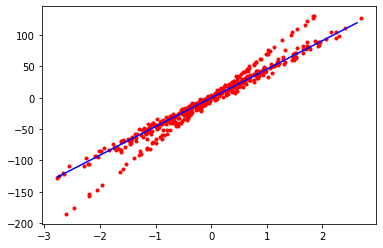

In [11]:
plt.scatter(X[:],y[:], marker='.', color = 'r')
plt.plot(x_line, y_line, '-', color = 'b')
plt.show()

### Comparación

In [12]:
def GD(theta=[], grad=None, gd_params={}, f_params={}):
    
    nIter = gd_params['nIter'] 
    alpha = gd_params['alpha']
    Theta=[]
    for t in range(nIter):
        p = grad(theta,f_params=f_params)
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

def SGD(theta=[], grad=None, gd_params=[], f_params=[]):

    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']
    
    nIter      = gd_params['nIter']
    alpha      = gd_params['alpha']
        
    Theta=[]
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        p = grad(theta,f_params=smpf_params)
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

def MGD(theta=[], grad=None, gd_params={}, f_params={}):

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
    return np.array(Theta)

def NAG(theta=[], grad=None, gd_params={}, f_params={}):

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    Theta=[]
    
    for t in range(nIter):
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=f_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

def ADADELTA(theta=[], grad=None, gd_params={}, f_params={}):

    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape) 
    Theta=[]
    for t in range(nIter):
        g = grad(theta, f_params=f_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    return np.array(Theta)

In [48]:
ThetaGD = GD(theta=theta, grad=grad_exp, 
             gd_params=gd_params, f_params=f_params)

ThetaSGD = SGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaMGD = MGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaNAG = NAG(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaADADELTA = ADADELTA(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

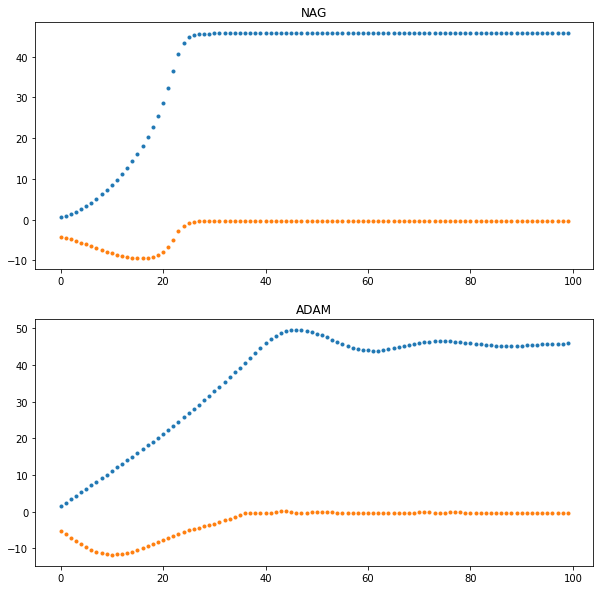

In [53]:
Tmax=100
plt.figure(figsize=(10,10))

plt.subplot(211)
plt.plot(ThetaNAG[:Tmax], '.')
plt.title('NAG')

plt.subplot(212)
plt.plot(ThetaADAM[:Tmax], '.')
plt.title('ADAM')

plt.show()

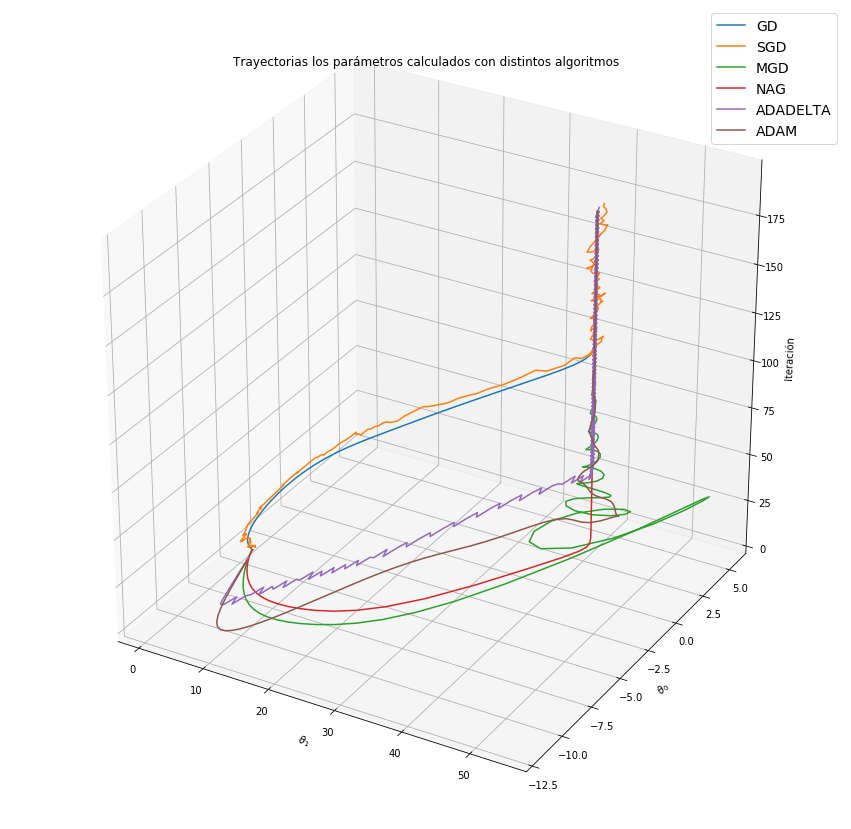

In [52]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
nIter=np.expand_dims(np.arange(ThetaGD.shape[0]),1) 
Tmax=200
ax.plot(ThetaGD[:Tmax,0],  ThetaGD [:Tmax,1], nIter[:Tmax,0], label='GD')
ax.plot(ThetaSGD[:Tmax,0], ThetaSGD[:Tmax,1], nIter[:Tmax,0], label='SGD')
ax.plot(ThetaMGD[:Tmax,0], ThetaMGD[:Tmax,1], nIter[:Tmax,0], label='MGD')
ax.plot(ThetaNAG[:Tmax,0], ThetaNAG[:Tmax,1], nIter[:Tmax,0], label='NAG')
ax.plot(ThetaADADELTA[:Tmax,0], ThetaADADELTA[:Tmax,1], nIter[:Tmax,0], label='ADADELTA')
ax.plot(ThetaADAM[:Tmax,0], ThetaADAM[:Tmax,1], nIter[:Tmax,0], label='ADAM')
ax.legend()
ax.set_title(r'Trayectorias los parámetros calculados con distintos algoritmos')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel('Iteración')
plt.show()

## Versión estocástica algoritmos

In [40]:
def MGD_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g = grad(theta, f_params=smpf_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
        
    return np.array(Theta)

def NAG_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=smpf_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

def ADADELTA_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape)
    
    Theta=[]
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g = grad(theta, f_params=smpf_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    
    return np.array(Theta)

def ADAM_s(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['X'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    
    Theta    = []
    eta1_t = eta1
    eta2_t = eta2

    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        
        g  = grad(theta, f_params=smpf_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        Theta.append(theta)
        
    return np.array(Theta)

In [55]:
ThetaSGD = SGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaMGD = MGD_s(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaNAG = NAG_s(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)

ThetaADADELTA = ADADELTA_s(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

ThetaADAM = ADAM_s(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)

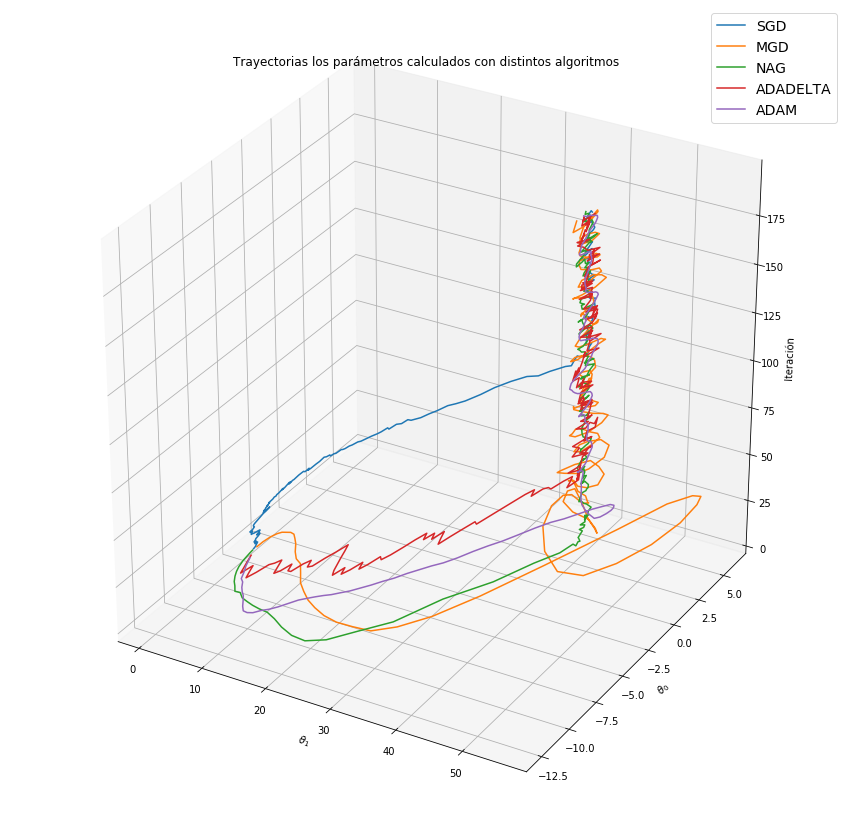

In [59]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
nIter=np.expand_dims(np.arange(ThetaGD.shape[0]),1) 
Tmax=200
ax.plot(ThetaSGD[:Tmax,0], ThetaSGD[:Tmax,1], nIter[:Tmax,0], label='SGD')
ax.plot(ThetaMGD[:Tmax,0], ThetaMGD[:Tmax,1], nIter[:Tmax,0], label='MGD')
ax.plot(ThetaNAG[:Tmax,0], ThetaNAG[:Tmax,1], nIter[:Tmax,0], label='NAG')
ax.plot(ThetaADADELTA[:Tmax,0], ThetaADADELTA[:Tmax,1], nIter[:Tmax,0], label='ADADELTA')
ax.plot(ThetaADAM[:Tmax,0], ThetaADAM[:Tmax,1], nIter[:Tmax,0], label='ADAM')
ax.legend()
ax.set_title(r'Trayectorias los parámetros calculados con distintos algoritmos')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel('Iteración')
plt.show()

## Radial Basis Functions

Se define la función de base radial con sus parámetros, $\mu$ y $\sigma$

In [68]:
import numpy as np
import matplotlib.pyplot as plt

N=1
i = np.linspace(-N,N,20)

def rbf_gaussian(i, m, sigma):
    
    r, th = (i-m), 1./(2.*sigma)
    return np.exp(-(th*r)**2)

Función para construir la matriz de datos $\Phi$ de dimensión $nxp$ usada para encontrar el vector $\beta$ óptimo de dimensión $p$

In [6]:
def build_design_matrix(y, mu, sigma, basis_size):
    
    phi = []

    for y_i in y:

        phi_i = np.array([rbf_gaussian(y_i, m=mu[i], sigma=sigma) for i in range(basis_size)]).reshape((1, basis_size))

        phi.append(phi_i)

    return np.concatenate(phi)

Función que regresa el gradiente de la función de costo respecto al vector de parámetros $\mu$

In [154]:
def grad_rbf(theta, f_params):

    y = f_params['y']
    Phi = f_params['Phi']
    beta = f_params['beta']
    sigma = f_params['sigma']
    grad = []

    y_hat = Phi.dot(beta)
    
    for i, param in enumerate(theta):
        
        prod1 = (Phi[:, i]*beta[i]).reshape((Phi.shape[0], 1))
        prod2 = (y-param).reshape((Phi.shape[0], 1))
        prod3 = y_hat*prod1*prod2
        grad_l = (2/sigma**2)*np.sum(prod3)*(1.0/f_params['batch_size'])
        grad.append(grad_l)
        
    return np.array(grad)

Algoritmo de descenso de gradiente ADAM

In [155]:
def ADAM_s_rbf(theta=[], grad=None, gd_params={}, f_params={}):
    
    high, dim = f_params['Phi'].shape
    batch_size = gd_params['batch_size']
    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADAM'] 
    eta1     = gd_params['eta1']
    eta2     = gd_params['eta2']
    p        = np.zeros(theta.shape)
    v        = 0.0
    
    Theta    = []
    Loss = []
    
    eta1_t = eta1
    eta2_t = eta2

    for t in range(nIter):
        
        # Set of sampled indices
        smpIdx = np.random.randint(low=0, high=high, size=batch_size, dtype='int32')
        # sample 
        smpPhi = f_params['Phi'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'Phi'     : smpPhi, 
                      'y'     : smpy,
                      'beta' : f_params['beta'],
                      'sigma' : f_params['sigma'],
                      'batch_size' : batch_size}
        
        g  = grad(theta, f_params=smpf_params)
        p  = eta1*p + (1.0-eta1)*g
        v  = eta2*v + (1.0-eta2)*(g**2)
        p_h = p/(1.-eta1_t)
        v_h = v/(1.-eta2_t)
        theta = theta - alpha * p_h / (np.sqrt(v_h)+epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        
        y_hat = f_params['Phi'].dot(f_params['beta'])
        Loss.append(np.linalg.norm(f_params['y']-y_hat)*(1./batch_size))
        
        Theta.append(theta)
        
    return np.array(Theta), Loss

Lee imagen (width x height x channels) y selecciona un solo canal (canal 0)

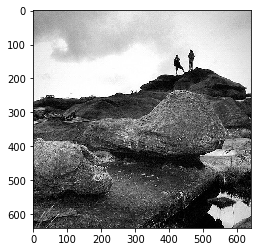

In [9]:
image = plt.imread('paisaje.jpg')[:, :, 0]

plt.imshow(image, interpolation='nearest')
plt.gray()
plt.show()

Selecciona una fila de la imagen

In [10]:
y = image[180, :].reshape(image.shape[0], 1)

Visualización de los valores de los pixeles del renglón de la imagen escogido

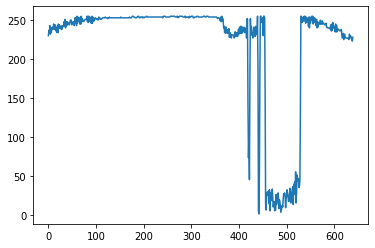

In [60]:
plt.plot(y)
plt.show()

#####

In [141]:
Phi = build_design_matrix(y, mu)
beta_hat = np.linalg.lstsq(Phi, y, rcond=None)[0].reshape((basis_size, 1))

In [187]:
y_hat = Phi.dot(beta_hat)

In [178]:
prod1 = (Phi[:, 6]*beta_hat[6]).reshape((Phi.shape[0], 1))

In [179]:
prod2 = (y-mu[6]).reshape((Phi.shape[0], 1))

In [194]:
prod3 = y_hat*prod1*prod2

In [195]:
grad = (2/sigma**2)*np.sum(prod3)

In [196]:
grad

199.4748364725255

In [207]:
thetaADAM = ADAM_s_rbf(theta=mu, grad=grad_rbf, 
                         gd_params=gd_params, f_params=f_params)[-1]

### Entrenamiento

Parámetros del algoritmo

In [184]:
gd_params = {'alphaADAM'      : 0.01,
             'nIter'          : 40,
             'batch_size'     : 256,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

# parámetros de la función objetivo

f_params = {'y'     : y, 
            'Phi'  : [],
            'beta' : []}

f_params['sigma'] = 10
f_params['basis_size'] = 10
f_params['epsilon'] = 0.1
f_params['mu'] = np.random.normal(np.mean(f_params['y']), f_params['sigma'], f_params['basis_size'])


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

Current iter: 101

Current iter: 111

Current iter: 121

Current iter: 131

Current iter: 141

Current iter: 151

Current iter: 161

Current iter: 171

Current iter: 181

Current iter: 191


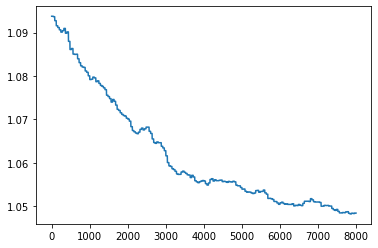

In [190]:
Loss = []
Mu = []

for i in range(200):
    
    mu_old = f_params['mu'][:]
    f_params['Phi'] = build_design_matrix(f_params['y'], f_params['mu'], f_params['sigma'], f_params['basis_size'])
    f_params['beta'] = np.linalg.lstsq(f_params['Phi'], f_params['y'], rcond=None)[0].reshape((f_params['basis_size'], 1))
    mu, loss = ADAM_s_rbf(theta=f_params['mu'], grad=grad_rbf, 
                         gd_params=gd_params, f_params=f_params)
    f_params['mu'] = mu[-1]
    
    Mu += list(mu)
    Loss += loss
    
    if i%10 == 0:
        
        print("\nCurrent iter: {0}".format(i+1))
    
    if np.linalg.norm(mu_old-f_params['mu']) < f_params['epsilon']:
        
        print("Stop at iteration {0}".format(i+1))
        break;
        
plt.plot(np.array(Loss))
plt.show()

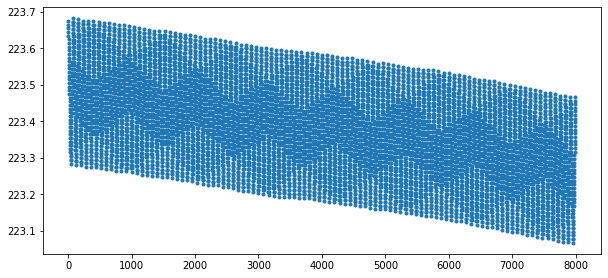

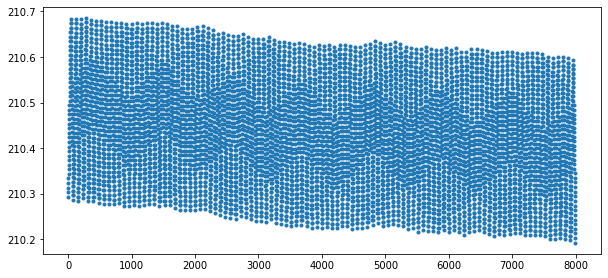

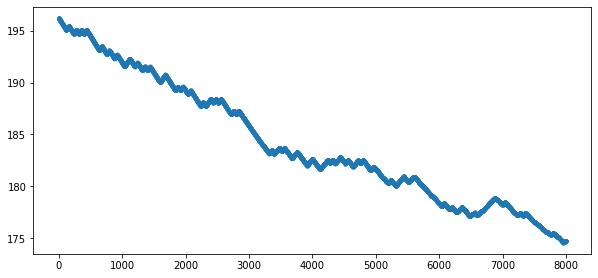

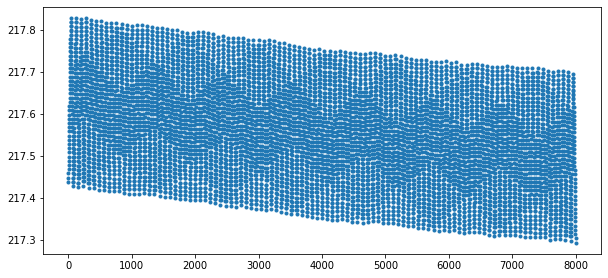

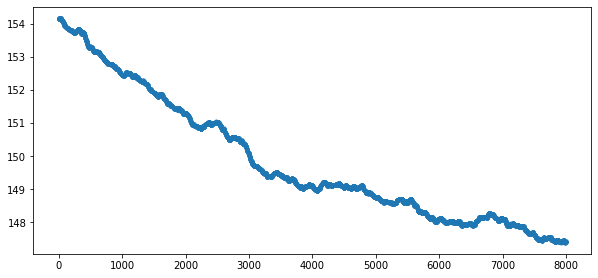

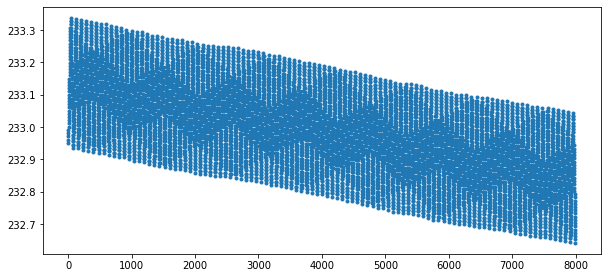

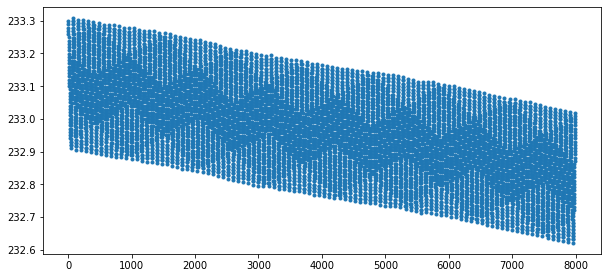

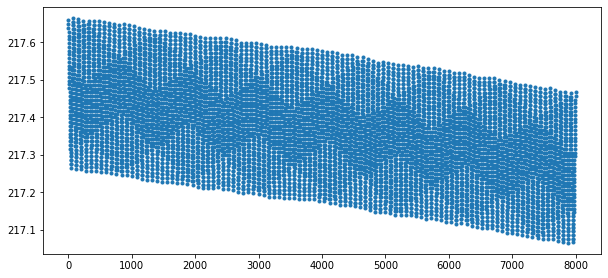

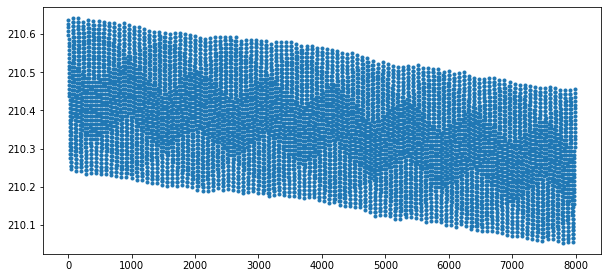

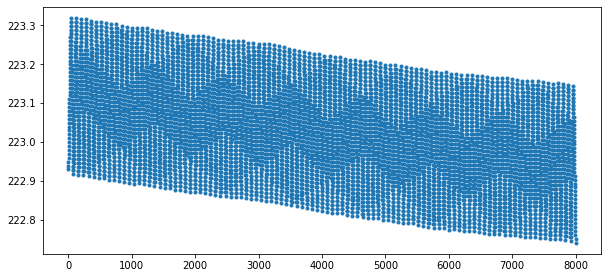

In [197]:
Mu_np = [np.array([u[i] for u in Mu]) for i in range(f_params['basis_size'])]

for m in Mu_np:
    
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.plot(m, '.')
    #plt.ylim([0, 255])
    plt.show()

In [198]:
f_params['beta']

array([[-8.61888341e+07],
       [ 9.16693636e+05],
       [-2.24765144e+00],
       [ 1.16417896e+07],
       [ 1.77779785e+02],
       [ 1.01958820e+06],
       [-1.18638220e+06],
       [-1.00402042e+07],
       [-6.52327967e+05],
       [ 8.44901042e+07]])

In [201]:
y_hat = f_params['Phi'].dot(f_params['beta'])
np.linalg.norm(f_params['y']-y_hat)*(1./gd_params['batch_size'])

1.0483934204093752

#### Reconstruyendo imagen, renglón a renglón, para comprobar que el modelo se ajusta correctamente a los datos

In [207]:
image = plt.imread('paisaje.jpg')[:, :, 0]

imagen_estimada = []
num_rows = image.shape[0]

gd_params = {'alphaADAM'      : 0.01,
             'nIter'          : 40,
             'batch_size'     : 256,
             'eta'            : 0.9,
             'eta1'           : 0.9,
             'eta2'           : 0.999}

# parámetros de la función objetivo

f_params = {'y'     : y, 
            'Phi'  : [],
            'beta' : []}

f_params['sigma'] = 10
f_params['basis_size'] = 10
f_params['epsilon'] = 0.1
f_params['mu'] = np.random.normal(np.mean(f_params['y']), f_params['sigma'], f_params['basis_size'])

for j in range(num_rows):
    
    print("\n Image row {} \n".format(j))
    
    f_params['y'] = image[j, :].reshape(image.shape[0], 1)
    
    for i in range(100):
    
        mu_old = f_params['mu'][:]
        f_params['Phi'] = build_design_matrix(f_params['y'], f_params['mu'], f_params['sigma'], f_params['basis_size'])
        f_params['beta'] = np.linalg.lstsq(f_params['Phi'], f_params['y'], rcond=None)[0].reshape((f_params['basis_size'], 1))
        mu, loss = ADAM_s_rbf(theta=f_params['mu'], grad=grad_rbf, 
                             gd_params=gd_params, f_params=f_params)
        f_params['mu'] = mu[-1]

        Mu += list(mu)
        Loss += loss

        if i%10 == 0:

            print("\nCurrent iter: {0}".format(i+1))

        if np.linalg.norm(mu_old-f_params['mu']) < f_params['epsilon']:

            print("Stop at iteration {0}".format(i+1))
            break;
            
        y_hat = f_params['Phi'].dot(f_params['beta'])
        
    imagen_estimada.append(y_hat)


 Image row 0 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 1 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 2 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 3 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 4 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 5 


Current 


Current iter: 91

 Image row 42 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 43 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 44 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 45 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 46 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 


Current iter: 71

Current iter: 81

Current iter: 91

 Image row 84 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 85 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 86 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 87 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 88 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

C


Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 126 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 127 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 128 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 129 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 130 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 


Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 168 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 169 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 170 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 171 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 172 


Current iter: 1

Current iter: 


Current iter: 81

Current iter: 91

 Image row 209 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 210 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 211 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 212 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 213 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 


Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 251 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 252 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 253 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 254 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 255 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 


Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 293 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 294 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 295 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 296 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 297 


Current iter: 1

Current iter: 


Current iter: 81

Current iter: 91

 Image row 334 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 335 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 336 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 337 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 338 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 


Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 376 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 377 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 378 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 379 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 380 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 


Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 418 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 419 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 420 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 421 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 422 


Current iter: 1

Current iter: 


Current iter: 81

Current iter: 91

 Image row 459 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 460 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 461 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 462 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 463 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 


Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 501 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 502 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 503 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 504 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 505 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 


Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 551 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 552 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 553 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 554 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 555 


Current iter: 1

Current iter: 


Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 593 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 594 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 595 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 596 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 597 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 


Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 635 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 636 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 637 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 638 


Current iter: 1

Current iter: 11

Current iter: 21

Current iter: 31

Current iter: 41

Current iter: 51

Current iter: 61

Current iter: 71

Current iter: 81

Current iter: 91

 Image row 639 


Current iter: 1

Current iter: 

#### Imagen reconstruida mediante RBF

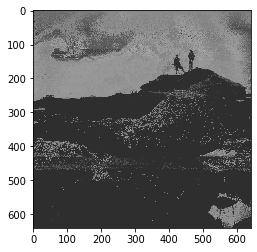

In [212]:
plt.imshow(np.array(imagen_estimada)[:,:,0], interpolation='nearest')
plt.gray()
plt.show()

#### Imagen original

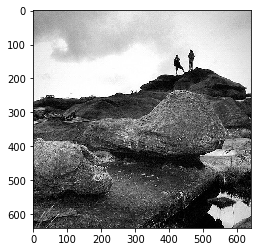

In [213]:
plt.imshow(image, interpolation='nearest')
plt.gray()
plt.show()